<a name="4"></a>
## Image compression with K-means

* In a straightforward 24-bit color representation of an image$^{2}$, each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. This encoding is often refered to as the RGB encoding.
* Our image contains thousands of colors, and  we will reduce the number ofcolors to 16 colors.
* By making this reduction, it is possible to represent (compress) the photo in an efficient way. 
* Specifically, we only need to store the RGB values of the 16 selected colors, and for each pixel in the image you now need to only store the index of the color at that location (where only 4 bits are necessary to represent 16 possibilities).

In this, we will use the K-means algorithm to select the 16 colors that will be used to represent the compressed image.
* Concretely, you will treat every pixel in the original image as a data example and use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in the 3- dimensional RGB space.
* Once we have computed the cluster centroids on the image, we will then use the 16 colors to replace the pixels in the original image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *

In [2]:
def compute_centroids(X, idx, K):
    m, n = X.shape
    centroids = np.zeros((K, n))
 
    for k in range(K):
        points=X[k==idx]  # To get a list of all data points in X assigned to centroid k
        centroids[k]=np.mean(points,axis=0)  # To compute the mean of the points assigned
    return centroids

In [3]:
def find_closest_centroids(X, centroids):
    # Set K
    K = centroids.shape[0]
    idx = np.zeros(X.shape[0], dtype=int)

    for i in range(X.shape[0]): 
        # Array to hold distance between X[i] and each centroids[j]
        distance = []                                  
        for j in range(centroids.shape[0]):
            norm_ij =np.linalg.norm(X[i]-centroids[j]) #To calculate the norm between (X[i] - centroids[j])
            distance.append(norm_ij)
        idx[i] =np.argmin(distance) #To calculate index of minimum value in distance

    return idx

In [4]:
def kMeans_init_centroids(X, K):
    # Randomly reorder the indices of examples
    randidx = np.random.permutation(X.shape[0])
    
    # Take the first K examples as centroids
    centroids = X[randidx[:K]]
    
    return centroids

In [5]:
def run_kMeans(X, initial_centroids, max_iters=10, plot_progress=False):
    # Initialize values
    m, n = X.shape
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids    
    idx = np.zeros(m)
    plt.figure(figsize=(8, 6))

    # Run K-Means
    for i in range(max_iters):
        
        #Output progress
        print("K-Means iteration %d/%d" % (i, max_iters-1))
        
        # For each example in X, assign it to the closest centroid
        idx = find_closest_centroids(X, centroids)
        
        # Optionally plot progress
        if plot_progress:
            plot_progress_kMeans(X, centroids, previous_centroids, idx, K, i)
            previous_centroids = centroids
            
        # Given the memberships, compute new centroids
        centroids = compute_centroids(X, idx, K)
    plt.show() 
    return centroids, idx

In [6]:
# Load an image 
original_img = plt.imread('bird_small.png')

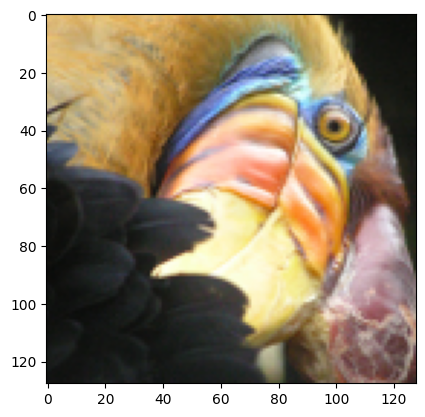

In [7]:
# Visualizing the image
plt.imshow(original_img)

In [8]:
print("Shape of original_img is:", original_img.shape)

Shape of original_img is: (128, 128, 3)


As We can see, this creates a three-dimensional matrix `original_img` where 
* the first two indices identify a pixel position, and
* the third index represents red, green, or blue. 

For example, `original_img[60, 23, 2]` gives the blue intensity of the pixel at row 60 and column 23.

#### Processing data

To call the `run_kMeans`, you need to first transform the matrix `original_img` into a two-dimensional matrix.

* The code below reshapes the matrix `original_img` to create an $m \times 3$ matrix of pixel colors (where
$m=16384 = 128\times128$)

In [9]:
# Divide by 255 so that all values are in the range 0 - 1 
# Reshape the image into an m x 3 matrix where m = number of pixels
# (in this case m = 128 x 128 = 16384)
# Each row will contain the Red, Green and Blue pixel values
# This gives us our dataset matrix X_img that we will use K-Means on.

X_img = np.reshape(original_img, (original_img.shape[0] * original_img.shape[1], 3))

In [10]:
K = 16
max_iters = 10

# Using the function we have implemented above. 
initial_centroids = kMeans_init_centroids(X_img, K)

# Run K-Means
centroids, idx = run_kMeans(X_img, initial_centroids, max_iters)

K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9


<Figure size 800x600 with 0 Axes>

In [11]:
print("Shape of idx:", idx.shape)
print("Closest centroid for the first five elements:", idx[:5])

Shape of idx: (16384,)
Closest centroid for the first five elements: [12  3  3  3 12]


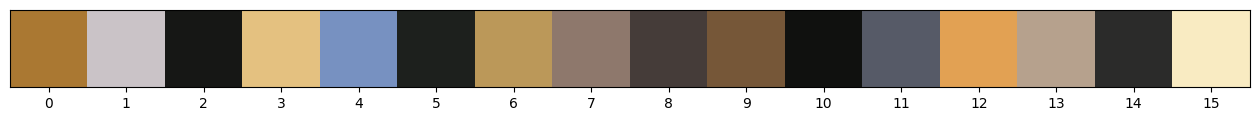

In [12]:
# Visualize the 16 colors selected
show_centroid_colors(centroids)

After finding the top $K=16$ colors to represent the image, We can now
assign each pixel position to its closest centroid using the
`find_closest_centroids` function. 
* This allows us to represent the original image using the centroid assignments of each pixel. 
* Notice that we have significantly reduced the number of bits that are required to describe the image. 
    * The original image required 24 bits (i.e. 8 bits x 3 channels in RGB encoding) for each one of the $128\times128$ pixel locations, resulting in total size of $128 \times 128 \times 24 = 393,216$ bits. 
    * The new representation requires some overhead storage in form of a dictionary of 16 colors, each of which require 24 bits, but the image itself then only requires 4 bits per pixel location. 
    * The final number of bits used is therefore $16 \times 24 + 128 \times 128 \times 4 = 65,920$ bits, which corresponds to compressing the original image by about a factor of 6.

In [13]:
# Find the closest centroid of each pixel
idx = find_closest_centroids(X_img, centroids)

# Replace each pixel with the color of the closest centroid
X_recovered = centroids[idx, :] 

# Reshape image into proper dimensions
X_recovered = np.reshape(X_recovered, original_img.shape) 

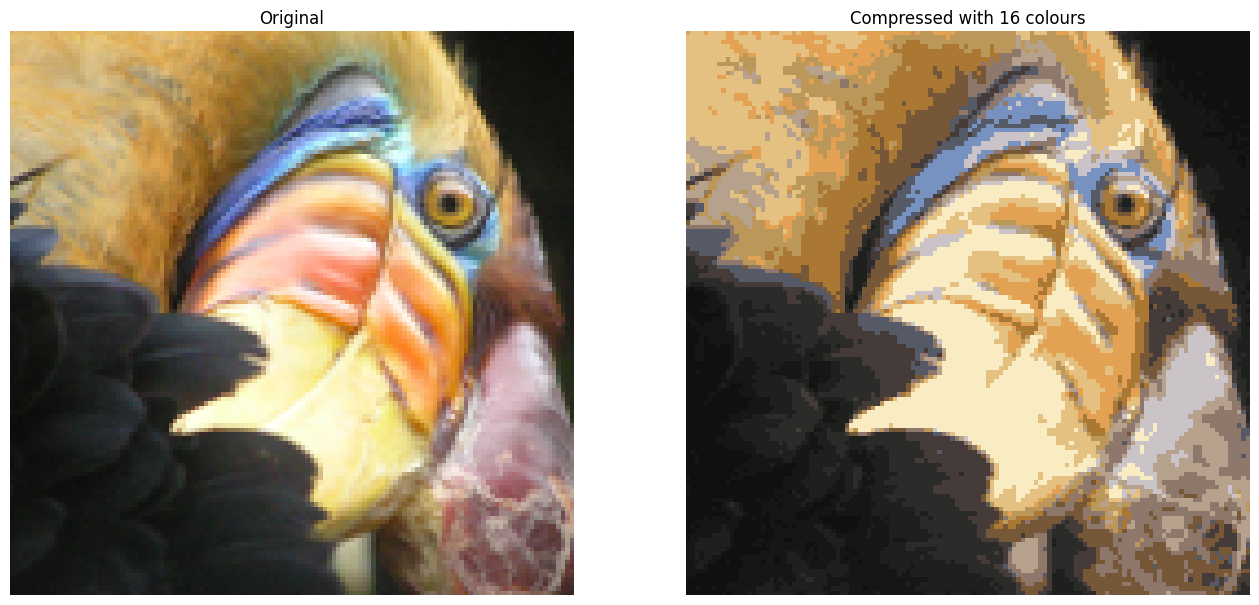

In [14]:
# Display original image
fig, ax = plt.subplots(1,2, figsize=(16,16))
plt.axis('off')

ax[0].imshow(original_img)
ax[0].set_title('Original')
ax[0].set_axis_off()


# Display compressed image
ax[1].imshow(X_recovered)
ax[1].set_title('Compressed with %d colours'%K)
ax[1].set_axis_off()

## Another Example 1

Shape of original_img: (240, 320, 3)
K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9


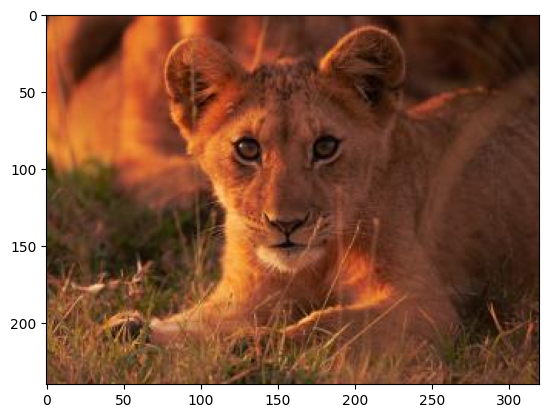

<Figure size 800x600 with 0 Axes>

Shape of idx: (76800,)
Closest centroid for the first five elements: [0 4 5 5 2]


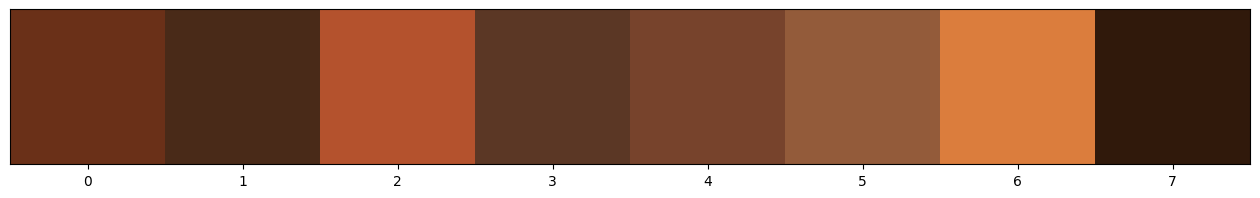

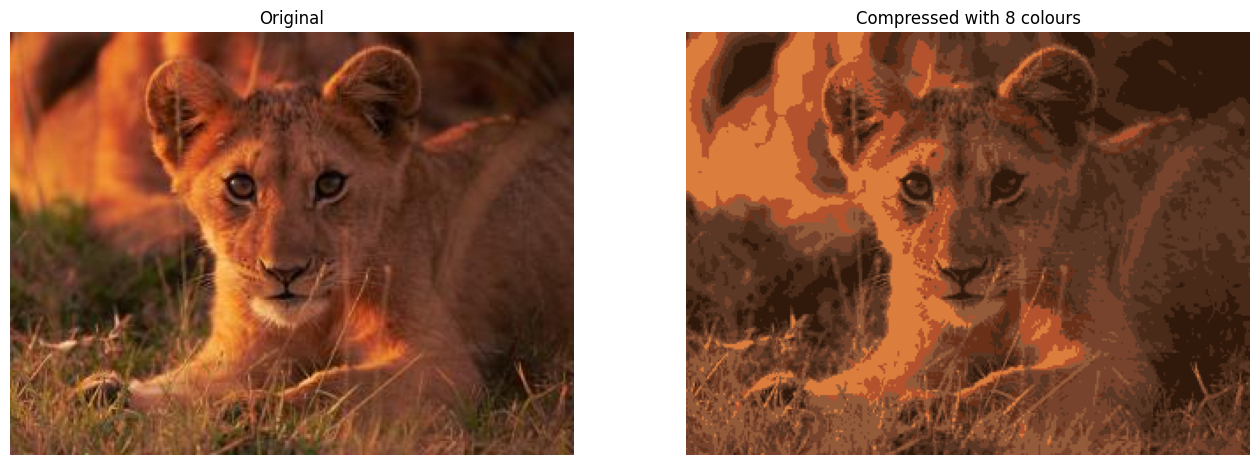

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *

def find_closest_centroids(X, centroids):
    K = centroids.shape[0]
    idx = np.zeros(X.shape[0], dtype=int)
    
    for i in range(X.shape[0]): 
        idx[i] = np.argmin(np.linalg.norm(X[i] - centroids, axis=1))
    
    return idx

def kMeans_init_centroids(X, K):
    randidx = np.random.permutation(X.shape[0])
    return X[randidx[:K]]

def run_kMeans(X, initial_centroids, max_iters=10, plot_progress=False):
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    idx = np.zeros(X.shape[0])
    
    plt.figure(figsize=(8, 6))

    for i in range(max_iters):
        print(f"K-Means iteration {i}/{max_iters-1}")
        
        idx = find_closest_centroids(X, centroids)
        
        if plot_progress:
            plot_progress_kMeans(X, centroids, centroids, idx, K, i)

        centroids = compute_centroids(X, idx, K)

    plt.show() 
    return centroids, idx

# Load and visualize image
original_img = plt.imread('lion.jpg')
plt.imshow(original_img)
print("Shape of original_img:", original_img.shape)

# Reshape image
normalized_img = original_img / 255.0

# Reshape into (pixels, 3) where pixels = height * width
X_img = np.reshape(normalized_img, (original_img.shape[0] * original_img.shape[1], 3))

# Run K-Means
K, max_iters = 8, 10
initial_centroids = kMeans_init_centroids(X_img, K)
centroids, idx = run_kMeans(X_img, initial_centroids, max_iters)

print("Shape of idx:", idx.shape)
print("Closest centroid for the first five elements:", idx[:5])

# Visualize centroid colors
show_centroid_colors(centroids)

# Replace each pixel with its closest centroid
X_recovered = centroids[idx, :].reshape(original_img.shape)

# Display original and compressed images
fig, ax = plt.subplots(1, 2, figsize=(16, 16))

ax[0].imshow(original_img)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(X_recovered)
ax[1].set_title(f'Compressed with {K} colours')
ax[1].axis('off')

plt.show()


## Another Example 2

Processing image: bright-autumn-festival.jpg


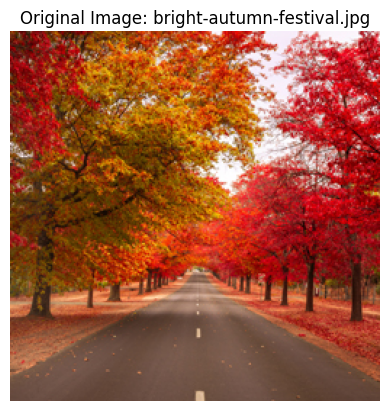

Shape of original_img: (255, 255, 3)
K-Means iteration 1/10
K-Means iteration 2/10
K-Means iteration 3/10
K-Means iteration 4/10
K-Means iteration 5/10
K-Means iteration 6/10
K-Means iteration 7/10
K-Means iteration 8/10
K-Means iteration 9/10
K-Means iteration 10/10


<Figure size 800x600 with 0 Axes>

Shape of idx: (65025,)
Closest centroid for the first five elements: [2 7 5 2 2]


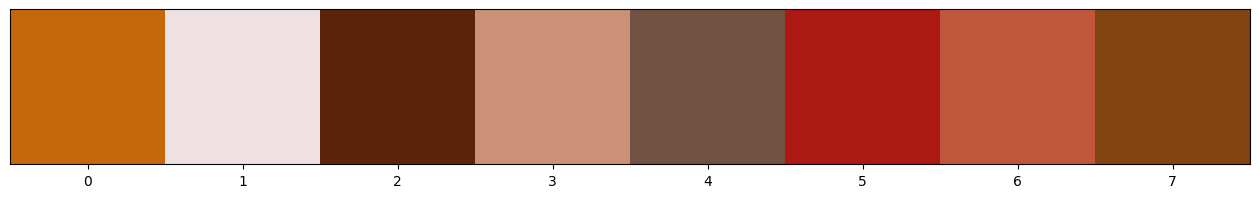

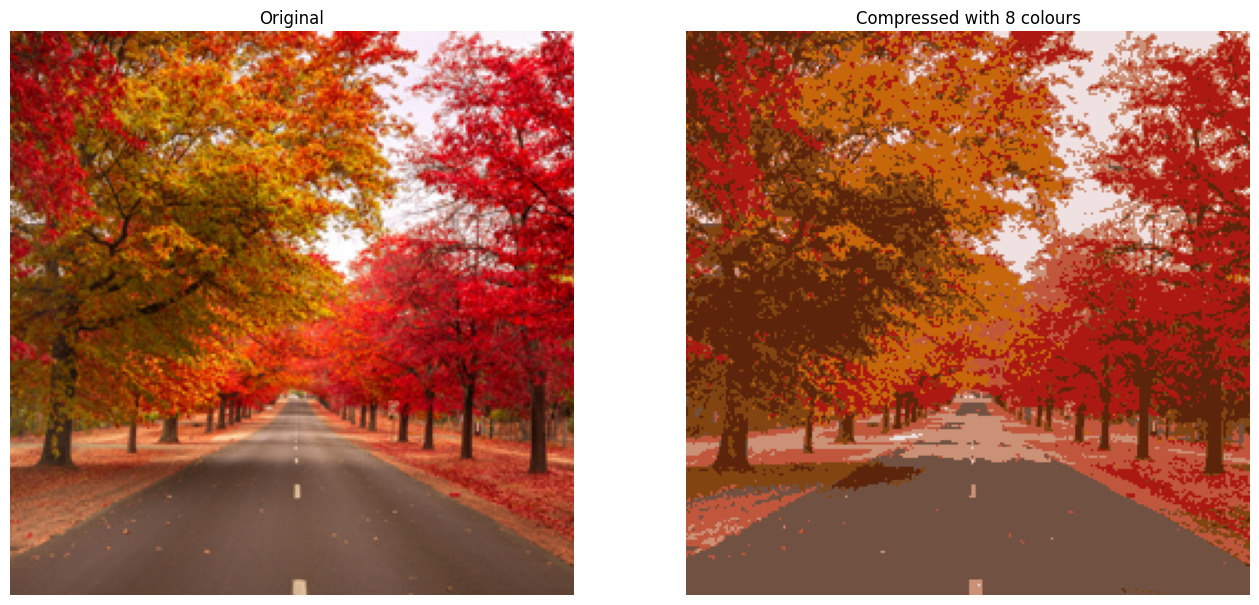

Saved compressed image: images1\compressed_bright-autumn-festival.jpg

Processing image: lion.jpg


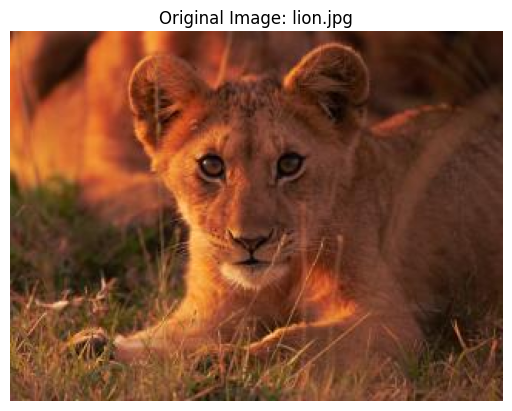

Shape of original_img: (240, 320, 3)
K-Means iteration 1/10
K-Means iteration 2/10
K-Means iteration 3/10
K-Means iteration 4/10
K-Means iteration 5/10
K-Means iteration 6/10
K-Means iteration 7/10
K-Means iteration 8/10
K-Means iteration 9/10
K-Means iteration 10/10


<Figure size 800x600 with 0 Axes>

Shape of idx: (76800,)
Closest centroid for the first five elements: [4 7 1 6 6]


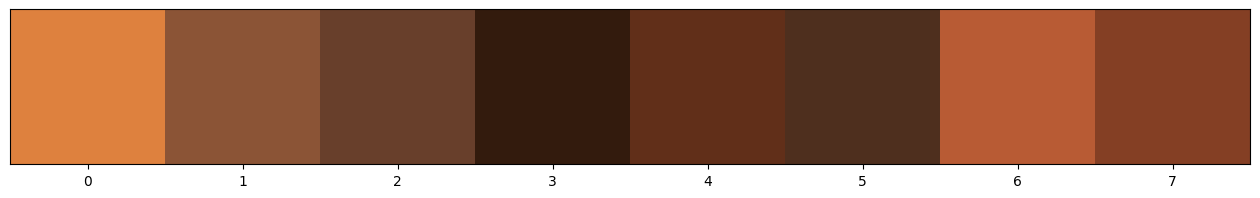

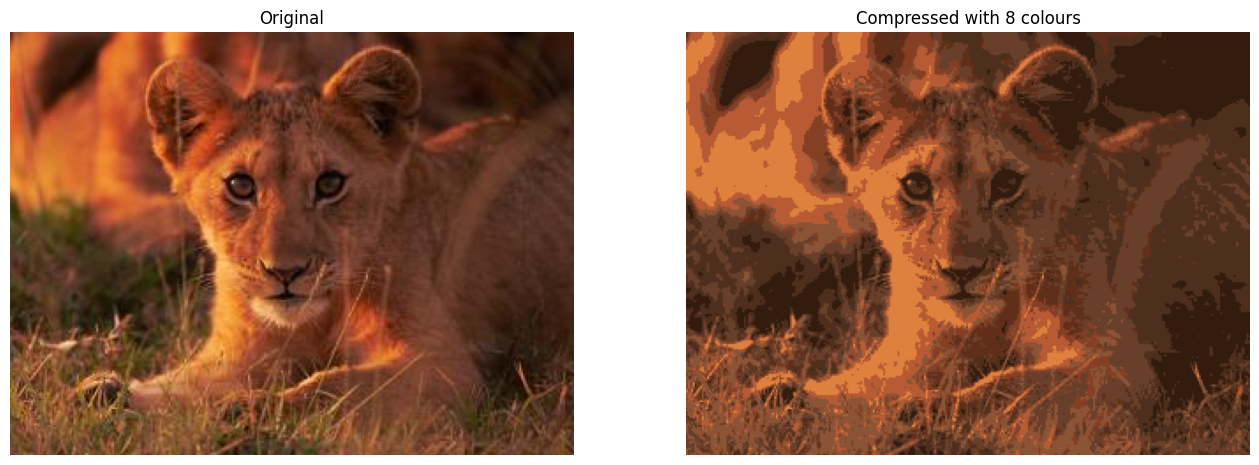

Saved compressed image: images1\compressed_lion.jpg



In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utils import *

def find_closest_centroids(X, centroids):
    K = centroids.shape[0]
    idx = np.zeros(X.shape[0], dtype=int)
    
    for i in range(X.shape[0]): 
        idx[i] = np.argmin(np.linalg.norm(X[i] - centroids, axis=1))
    
    return idx

def kMeans_init_centroids(X, K):
    randidx = np.random.permutation(X.shape[0])
    return X[randidx[:K]]

def run_kMeans(X, initial_centroids, max_iters=10, plot_progress=False):
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    idx = np.zeros(X.shape[0])
    
    plt.figure(figsize=(8, 6))

    for i in range(max_iters):
        print(f"K-Means iteration {i+1}/{max_iters}")
        
        idx = find_closest_centroids(X, centroids)
        
        if plot_progress:
            plot_progress_kMeans(X, centroids, centroids, idx, K, i)

        centroids = compute_centroids(X, idx, K)

    plt.show() 
    return centroids, idx

# Directory containing images
image_folder = "images1"  

# Ensure the folder exists
if not os.path.exists(image_folder):
    print(f"Error: Folder '{image_folder}' not found.")
else:
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    if not image_files:
        print("No image files found in the folder.")

    # Process each image
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        print(f"Processing image: {image_file}")

        # Load and visualize image
        original_img = plt.imread(image_path)
        plt.imshow(original_img)
        plt.title(f"Original Image: {image_file}")
        plt.axis('off')
        plt.show()

        print("Shape of original_img:", original_img.shape)

        # Normalize and reshape image
        normalized_img = original_img / 255.0
        X_img = np.reshape(normalized_img, (-1, 3))  # Flatten into (pixels, 3)

        # Run K-Means
        K, max_iters = 8, 10
        initial_centroids = kMeans_init_centroids(X_img, K)
        centroids, idx = run_kMeans(X_img, initial_centroids, max_iters)

        print("Shape of idx:", idx.shape)
        print("Closest centroid for the first five elements:", idx[:5])

        # Visualize centroid colors
        show_centroid_colors(centroids)

        # Replace each pixel with its closest centroid
        X_recovered = centroids[idx, :].reshape(original_img.shape)

        # Display original and compressed images
        fig, ax = plt.subplots(1, 2, figsize=(16, 16))

        ax[0].imshow(original_img)
        ax[0].set_title('Original')
        ax[0].axis('off')

        ax[1].imshow(X_recovered)
        ax[1].set_title(f'Compressed with {K} colours')
        ax[1].axis('off')

        plt.show()

        # Save compressed image
        output_path = os.path.join(image_folder, f"compressed_{image_file}")
        plt.imsave(output_path, X_recovered)
        print(f"Saved compressed image: {output_path}\n")
